In [62]:
# In[1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.cuda.amp import GradScaler, autocast
from tqdm.notebook import tqdm  # Use tqdm.notebook for notebooks
import os
import copy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

In [ ]:
# In[2]:
class Config:
    # --- Dataset & Hardware ---
    # DATA_DIR = 'path/to/your/soyabean_uav_dataset' # <--- CHANGE THIS
    # DATA_DIR = '/home/dragoon/Downloads/dataset' # <--- CHANGE THIS
    DATA_DIR = '/home/dragoon/Downloads/split' # <--- CHANGE THIS
    # DATA_DIR = '/home/dragoon/Downloads/testset' # <--- CHANGE THIS
    # DATA_DIR = '/home/dragoon/Downloads/testset' # <--- CHANGE THIS
    NUM_WORKERS = 4 

    # --- Model Architecture ---
    IMG_SIZE = 128
    HIDDEN_LAYERS_CONFIG = [32, 64, 128, 256] 
    HIDDEN_SIZE_CLASSIFIER = 512

    # --- Training Hyperparameters ---
    NUM_EPOCHS = 100
    BATCH_SIZE = 16
    # BATCH_SIZE = 4
    LEARNING_RATE = 1e-3
    
    # --- Early Stopping ---
    EARLY_STOP_PATIENCE = 7 
    MIN_LR_TO_START_EARLY_STOPPING = 1e-5 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [64]:
# In[3]:
train_transform = transforms.Compose([
    transforms.Resize((Config.IMG_SIZE, Config.IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
val_transform = transforms.Compose([
    transforms.Resize((Config.IMG_SIZE, Config.IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

try:
    full_dataset = torchvision.datasets.ImageFolder(root=Config.DATA_DIR, transform=train_transform)
    print(f"Found {len(full_dataset)} images in total.")
    class_names = full_dataset.classes
    NUM_CLASSES = len(class_names)
    print(f"Successfully detected {NUM_CLASSES} classes: {class_names}")

    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
    
    val_dataset.dataset.transform = val_transform

    train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, shuffle=True, num_workers=Config.NUM_WORKERS, pin_memory=True,drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=Config.BATCH_SIZE, shuffle=False, num_workers=Config.NUM_WORKERS, pin_memory=True)
except FileNotFoundError:
    print(f"ERROR: Dataset not found at '{Config.DATA_DIR}'. Please check the path.")

Found 58 images in total.
Successfully detected 4 classes: ['Soyabean Semilooper_Pest_Attack', 'healthy', 'mosaic', 'rust']


# In[4]:
def show_transformed_images(data_loader, class_names, num_images=3):
    # Un-normalize and display an image
    def imshow(inp, title=None):
        inp = inp.numpy().transpose((1, 2, 0))
        mean = np.array([0.5, 0.5, 0.5])
        std = np.array([0.5, 0.5, 0.5])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)
        plt.imshow(inp)
        if title is not None:
            plt.title(title)
        plt.pause(0.001)

    # Get a batch of training data
    inputs, classes = next(iter(data_loader))
    
    # Make a grid from the batch and show
    out = torchvision.utils.make_grid(inputs[:num_images*len(class_names)])
    
    fig, ax = plt.subplots(figsize=(15, 8))
    imshow(out, title=[class_names[x] for x in classes[:num_images*len(class_names)]])

print("Displaying a sample of transformed images...")
show_transformed_images(train_loader, class_names)

Displaying a sample of transformed images...


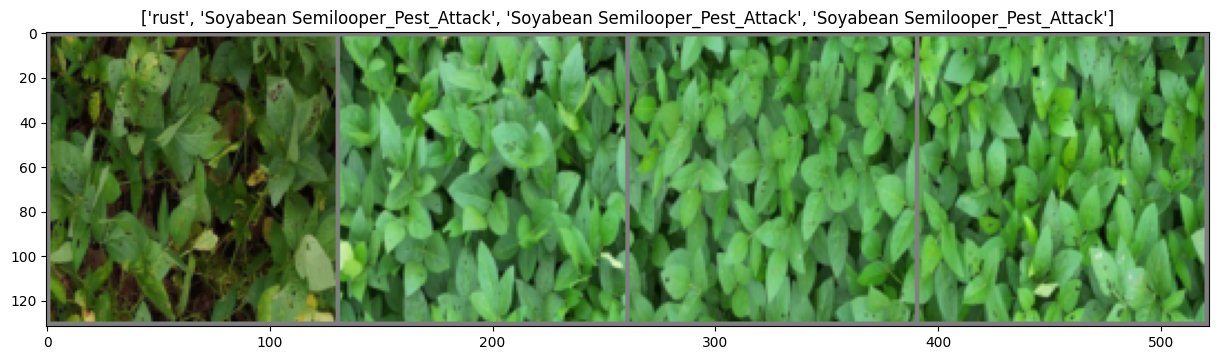

In [65]:
# In[4]:
def show_transformed_images(data_loader, class_names, num_images=3):
    # Un-normalize and display an image
    def imshow(inp, title=None):
        inp = inp.numpy().transpose((1, 2, 0))
        mean = np.array([0.5, 0.5, 0.5])
        std = np.array([0.5, 0.5, 0.5])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)
        plt.imshow(inp)
        if title is not None:
            plt.title(title)
        plt.pause(0.001)

    # Get a batch of training data
    inputs, classes = next(iter(data_loader))
    
    # Make a grid from the batch and show
    out = torchvision.utils.make_grid(inputs[:num_images*len(class_names)])
    
    fig, ax = plt.subplots(figsize=(15, 8))
    imshow(out, title=[class_names[x] for x in classes[:num_images*len(class_names)]])

print("Displaying a sample of transformed images...")
show_transformed_images(train_loader, class_names)

In [66]:
# In[5]:
class Binarize(torch.autograd.Function):
    @staticmethod
    def forward(ctx, i): return i.sign()
    @staticmethod
    def backward(ctx, grad_output): return grad_output

class BinaryConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
    def forward(self, x):
        self.conv.weight.data = Binarize.apply(self.conv.weight.data)
        return Binarize.apply(self.bn(self.conv(x)))

class BinaryLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features, bias=False)
        self.bn = nn.BatchNorm1d(out_features)
    def forward(self, x):
        self.linear.weight.data = Binarize.apply(self.linear.weight.data)
        return Binarize.apply(self.bn(self.linear(x)))

class BNN(nn.Module):
    def __init__(self, config, num_classes):
        super(BNN, self).__init__()
        layers = []
        in_channels = 3
        for out_channels in config.HIDDEN_LAYERS_CONFIG:
            layers.append(BinaryConv2d(in_channels, out_channels, kernel_size=3, padding=1))
            layers.append(nn.MaxPool2d(2))
            in_channels = out_channels
        self.features = nn.Sequential(*layers)
        num_pools = len(config.HIDDEN_LAYERS_CONFIG)
        final_img_size = config.IMG_SIZE // (2**num_pools)
        flat_size = config.HIDDEN_LAYERS_CONFIG[-1] * final_img_size * final_img_size
        self.classifier = nn.Sequential(
            BinaryLinear(flat_size, config.HIDDEN_SIZE_CLASSIFIER),
            nn.Linear(config.HIDDEN_SIZE_CLASSIFIER, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [67]:

import time
def train_model(model, train_loader, val_loader, config, model_name):
    print(f"\n--- Training {model_name} ---")
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config.LEARNING_RATE)
    # Added verbose=True to see when LR changes
    scheduler = ReduceLROnPlateau(optimizer, 'max', factor=0.2, patience=3)
    scaler = GradScaler()
    
    best_acc = 0.0
    patience_counter = 0
    history = {'train_loss': [], 'val_loss': [], 'val_acc': [], 'epoch_time': []} 

    for epoch in range(config.NUM_EPOCHS):
        start_time = time.time() # Start timer at the beginning of the epoch
        model.train()
        epoch_train_loss = 0.0
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{config.NUM_EPOCHS}", leave=False)
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            epoch_train_loss += loss.item() * images.size(0)
            loop.set_postfix(loss=loss.item())
        
        val_loss, val_acc = evaluate_model(model, val_loader, criterion)
        history['train_loss'].append(epoch_train_loss / len(train_loader.dataset))
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{config.NUM_EPOCHS} -> Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | LR: {current_lr:.1e}")
        
        scheduler.step(val_acc)
        
        # --- FIXED: Record epoch time inside the loop ---
        end_time = time.time()
        history['epoch_time'].append(end_time - start_time)

        if val_acc > best_acc:
            best_acc, patience_counter = val_acc, 0
            # --- FIXED: Use the 'model_name' parameter for saving ---
            torch.save(model.state_dict(), f"{model_name}_best.pt")
            print(f"  -> New best model saved with accuracy: {best_acc:.2f}%")
        else:
            if current_lr < config.MIN_LR_TO_START_EARLY_STOPPING:
                patience_counter += 1
                print(f"  -> No improvement. Patience: {patience_counter}/{config.EARLY_STOP_PATIENCE}")
        if patience_counter >= config.EARLY_STOP_PATIENCE:
            print("\n*** Early stopping triggered ***")
            break

    print(f"Finished training. Best Val Acc: {best_acc:.2f}%")
    # --- FIXED: Load the correctly named best model ---
    model.load_state_dict(torch.load(f"{model_name}_best.pt"))
    return model, history

def evaluate_model(model, data_loader, criterion):
    model.eval()
    model.to(device)
    correct, total, running_loss = 0, 0, 0.0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item() * images.size(0)
    accuracy = 100 * correct / total
    avg_loss = running_loss / len(data_loader.dataset)
    return avg_loss, accuracy

In [68]:
# In[7]:

from datetime import datetime
import pytz

# Define the IST timezone
ist_timezone = pytz.timezone('Asia/Kolkata')

# Get the current time in IST
current_ist_time = datetime.now(ist_timezone)

# Print the current IST time
print("Current IST Time:", current_ist_time.strftime("%Y-%m-%d %H:%M:%S %Z%z"))
def plot_curves(history, model_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    ax1.plot(history['train_loss'], label='Training Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_title(f'{model_name} - Loss Curves')
    ax1.set_xlabel('Epochs'); ax1.set_ylabel('Loss'); ax1.legend()
    ax2.plot(history['val_acc'], label='Validation Accuracy', color='green')
    ax2.set_title(f'{model_name} - Accuracy Curve')
    ax2.set_xlabel('Epochs'); ax2.set_ylabel('Accuracy (%)'); ax2.legend()
    plt.tight_layout()
    plt.savefig(f"{model_name}_performance_curves.png")
    print(f"Performance curves saved to {model_name}_performance_curves.png")
    plt.show()

def plot_confusion_matrix(model, data_loader, class_names, model_name):
    model.eval(); model.to(device)
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            with autocast():
                outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted Label'); plt.ylabel('True Label')
    plt.savefig(f"{model_name}_confusion_matrix{current_ist_time}.png")
    print(f"Confusion matrix saved to {model_name}_confusion_matrix{current_ist_time}.png")
    plt.show()

def get_model_size_mb(model):
    torch.save(model.state_dict(), "temp.p")
    size_mb = os.path.getsize("temp.p") / 1e6
    os.remove("temp.p")
    return size_mb

Current IST Time: 2025-07-19 08:04:00 IST+0530



--- Training BNN_20250719_080400 ---


/tmp/ipykernel_5120/2873454332.py:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch 1/100:   0%|          | 0/11 [00:00<?, ?it/s]

/tmp/ipykernel_5120/2873454332.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/100 -> Val Loss: 1.4921 | Val Acc: 33.33% | LR: 1.0e-03
  -> New best model saved with accuracy: 33.33%


/tmp/ipykernel_5120/2873454332.py:71: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 2/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 2/100 -> Val Loss: 1.3650 | Val Acc: 33.33% | LR: 1.0e-03


Epoch 3/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 3/100 -> Val Loss: 1.1920 | Val Acc: 58.33% | LR: 1.0e-03
  -> New best model saved with accuracy: 58.33%


Epoch 4/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 4/100 -> Val Loss: 0.9515 | Val Acc: 66.67% | LR: 1.0e-03
  -> New best model saved with accuracy: 66.67%


Epoch 5/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 5/100 -> Val Loss: 0.8708 | Val Acc: 58.33% | LR: 1.0e-03


Epoch 6/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 6/100 -> Val Loss: 0.7636 | Val Acc: 66.67% | LR: 1.0e-03


Epoch 7/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 7/100 -> Val Loss: 0.6493 | Val Acc: 83.33% | LR: 1.0e-03
  -> New best model saved with accuracy: 83.33%


Epoch 8/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 8/100 -> Val Loss: 0.6661 | Val Acc: 75.00% | LR: 1.0e-03


Epoch 9/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 9/100 -> Val Loss: 0.7314 | Val Acc: 83.33% | LR: 1.0e-03


Epoch 10/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 10/100 -> Val Loss: 0.6031 | Val Acc: 75.00% | LR: 1.0e-03


Epoch 11/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 11/100 -> Val Loss: 0.6658 | Val Acc: 66.67% | LR: 1.0e-03


Epoch 12/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 12/100 -> Val Loss: 0.5940 | Val Acc: 75.00% | LR: 2.0e-04


Epoch 13/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 13/100 -> Val Loss: 0.6117 | Val Acc: 75.00% | LR: 2.0e-04


Epoch 14/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 14/100 -> Val Loss: 0.4893 | Val Acc: 91.67% | LR: 2.0e-04
  -> New best model saved with accuracy: 91.67%


Epoch 15/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 15/100 -> Val Loss: 0.6615 | Val Acc: 75.00% | LR: 2.0e-04


Epoch 16/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 16/100 -> Val Loss: 0.7531 | Val Acc: 58.33% | LR: 2.0e-04


Epoch 17/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 17/100 -> Val Loss: 0.6318 | Val Acc: 83.33% | LR: 2.0e-04


Epoch 18/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 18/100 -> Val Loss: 0.6744 | Val Acc: 83.33% | LR: 2.0e-04


Epoch 19/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 19/100 -> Val Loss: 0.5936 | Val Acc: 83.33% | LR: 4.0e-05


Epoch 20/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 20/100 -> Val Loss: 0.6145 | Val Acc: 83.33% | LR: 4.0e-05


Epoch 21/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 21/100 -> Val Loss: 0.6581 | Val Acc: 58.33% | LR: 4.0e-05


Epoch 22/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 22/100 -> Val Loss: 0.5459 | Val Acc: 91.67% | LR: 4.0e-05


Epoch 23/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 23/100 -> Val Loss: 0.6866 | Val Acc: 66.67% | LR: 8.0e-06
  -> No improvement. Patience: 1/7


Epoch 24/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 24/100 -> Val Loss: 0.4108 | Val Acc: 91.67% | LR: 8.0e-06
  -> No improvement. Patience: 2/7


Epoch 25/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 25/100 -> Val Loss: 0.4820 | Val Acc: 83.33% | LR: 8.0e-06
  -> No improvement. Patience: 3/7


Epoch 26/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 26/100 -> Val Loss: 0.3374 | Val Acc: 100.00% | LR: 8.0e-06
  -> New best model saved with accuracy: 100.00%


Epoch 27/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 27/100 -> Val Loss: 0.6210 | Val Acc: 83.33% | LR: 8.0e-06
  -> No improvement. Patience: 1/7


Epoch 28/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 28/100 -> Val Loss: 0.3962 | Val Acc: 100.00% | LR: 8.0e-06
  -> No improvement. Patience: 2/7


Epoch 29/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 29/100 -> Val Loss: 0.5080 | Val Acc: 75.00% | LR: 8.0e-06
  -> No improvement. Patience: 3/7


Epoch 30/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 30/100 -> Val Loss: 0.4488 | Val Acc: 83.33% | LR: 8.0e-06
  -> No improvement. Patience: 4/7


Epoch 31/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 31/100 -> Val Loss: 0.4793 | Val Acc: 83.33% | LR: 1.6e-06
  -> No improvement. Patience: 5/7


Epoch 32/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 32/100 -> Val Loss: 0.5673 | Val Acc: 83.33% | LR: 1.6e-06
  -> No improvement. Patience: 6/7


Epoch 33/100:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 33/100 -> Val Loss: 0.4669 | Val Acc: 91.67% | LR: 1.6e-06
  -> No improvement. Patience: 7/7

*** Early stopping triggered ***
Finished training. Best Val Acc: 100.00%
Performance curves saved to BNN_20250719_080400_performance_curves.png


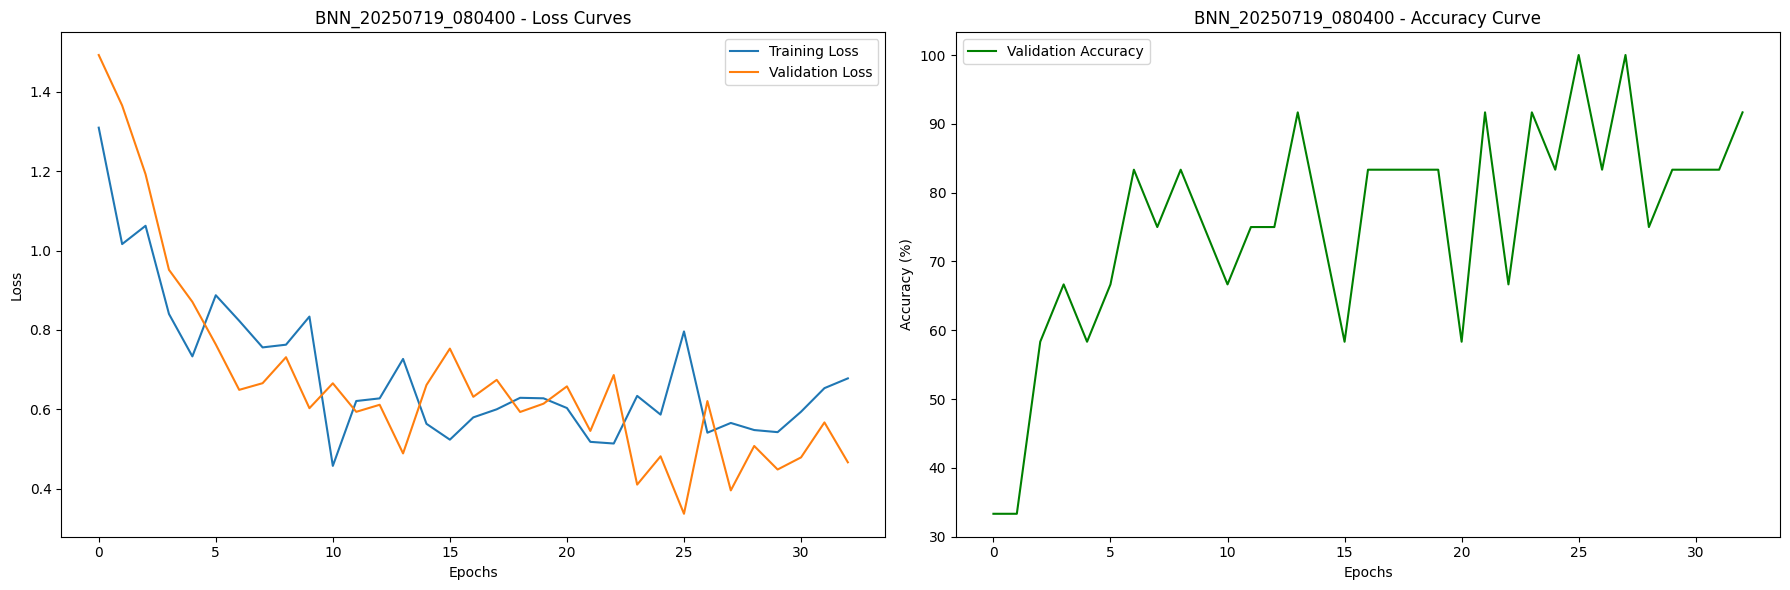

/tmp/ipykernel_5120/1421376743.py:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Confusion matrix saved to BNN_20250719_080400_confusion_matrix2025-07-19 08:04:00.540103+05:30.png


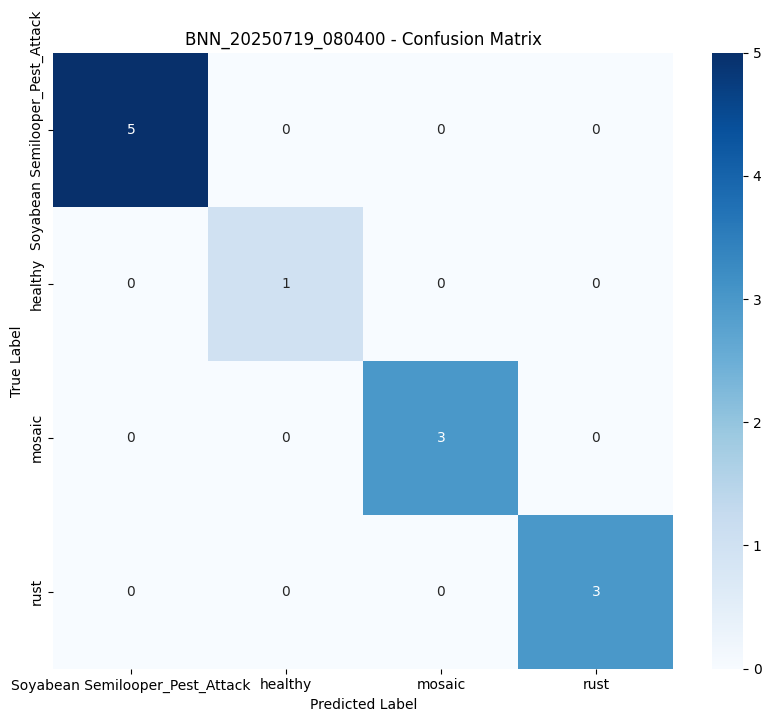



--- FINAL BNN RESULTS ---
BNN Final Validation Accuracy: 100.00%
BNN Final Model Size: 35.14 MB


/tmp/ipykernel_5120/2873454332.py:71: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


In [69]:
# In[8]:
run_timestamp = datetime.now(ist_timezone).strftime("%Y%m%d_%H%M%S")
model_name = f"BNN_{run_timestamp}" 
bnn_model = BNN(config=Config, num_classes=NUM_CLASSES)
trained_bnn, history = train_model(bnn_model, train_loader, val_loader, Config, model_name)
plot_curves(history, model_name)
plot_confusion_matrix(trained_bnn, val_loader, class_names, model_name)

print("\n\n--- FINAL BNN RESULTS ---")
print("="*25)
_, final_accuracy = evaluate_model(trained_bnn, val_loader, nn.CrossEntropyLoss())
model_size = get_model_size_mb(trained_bnn)
print(f"BNN Final Validation Accuracy: {final_accuracy:.2f}%")
print(f"BNN Final Model Size: {model_size:.2f} MB")
print("="*25)

In [70]:
# In[9]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import collections

def plot_roc_auc_curves(model, data_loader, class_names, model_name):
    model.eval()
    model.to(device)
    y_true = []
    y_scores = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            with autocast():
                outputs = model(images)
                # Use softmax to get probabilities
                scores = torch.softmax(outputs, dim=1)
            y_scores.extend(scores.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    # Binarize the labels for multi-class ROC
    y_true_binarized = label_binarize(y_true, classes=range(len(class_names)))
    y_scores = np.array(y_scores)
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 8))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])
    for i, color in zip(range(len(class_names)), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of class {class_names[i]} (area = {roc_auc[i]:0.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} - Multi-Class ROC/AUC Curves')
    plt.legend(loc="lower right")
    plt.savefig(f"{model_name}_roc_auc_curves.png")
    print(f"ROC/AUC curves saved to {model_name}_roc_auc_curves.png")
    plt.show()

def plot_epoch_times(history, model_name):
    plt.figure(figsize=(12, 6))
    plt.bar(range(1, len(history['epoch_time']) + 1), history['epoch_time'], color='teal')
    plt.title(f'{model_name} - Time Taken Per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Time (seconds)')
    plt.savefig(f"{model_name}_epoch_times.png")
    print(f"Epoch times chart saved to {model_name}_epoch_times.png")
    plt.show()

def plot_class_balance(dataset, class_names, model_name):
    class_counts = collections.Counter(dataset.targets)
    counts = [class_counts[i] for i in range(len(class_names))]
    
    plt.figure(figsize=(8, 8))
    plt.pie(counts, labels=class_names, autopct='%1.1f%%', startangle=140)
    plt.title(f'{model_name} - Dataset Class Balance')
    plt.axis('equal')
    plt.savefig(f"{model_name}_class_balance.png")
    print(f"Class balance pie chart saved to {model_name}_class_balance.png")
    plt.show()

def save_report(config, full_dataset, train_dataset, val_dataset, history, model_name):
    with open(f"{model_name}_report.txt", "w") as f:
        f.write("="*30 + "\n")
        f.write(f"Training Report for: {model_name}\n")
        f.write("="*30 + "\n\n")

        f.write("## Configuration ##\n")
        for key, value in vars(config).items():
            if not key.startswith('__'):
                f.write(f"{key}: {value}\n")
        
        f.write("\n## Dataset Information ##\n")
        f.write(f"Total Images: {len(full_dataset)}\n")
        f.write(f"Training Images: {len(train_dataset)}\n")
        f.write(f"Validation Images: {len(val_dataset)}\n\n")
        
        f.write("Class Distribution:\n")
        class_counts = collections.Counter(full_dataset.targets)
        for i, class_name in enumerate(full_dataset.classes):
            f.write(f"  - {class_name}: {class_counts[i]} images\n")

        f.write("\n## Training Summary ##\n")
        total_training_time = sum(history['epoch_time'])
        f.write(f"Total Training Time: {total_training_time:.2f} seconds\n")
        f.write(f"Number of Epochs Trained: {len(history['epoch_time'])}\n")

    print(f"Configuration and dataset report saved to {model_name}_report.txt")

Class balance pie chart saved to BNN_class_balance.png


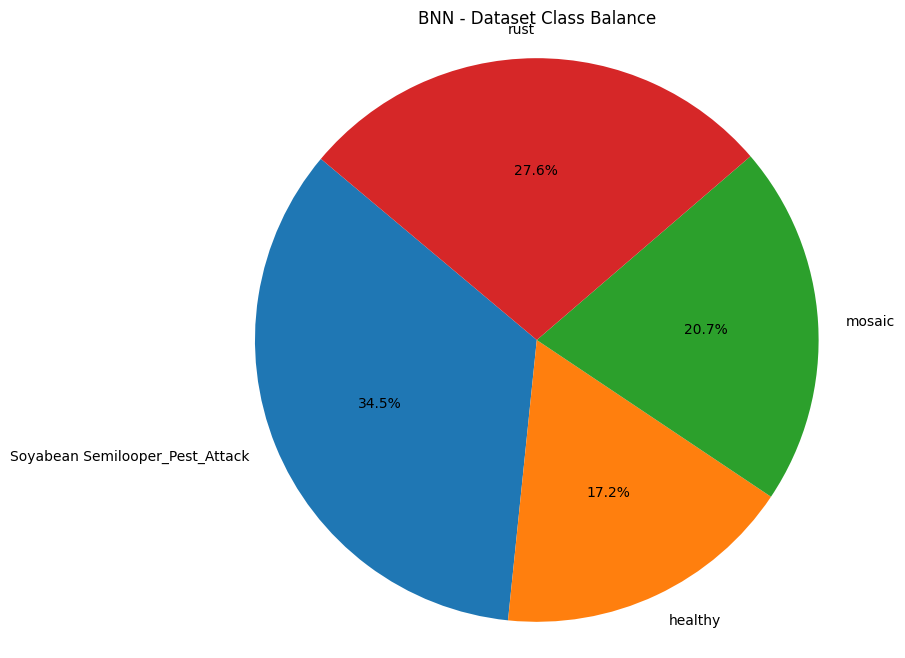

/tmp/ipykernel_5120/3905505421.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


ROC/AUC curves saved to BNN_roc_auc_curves.png


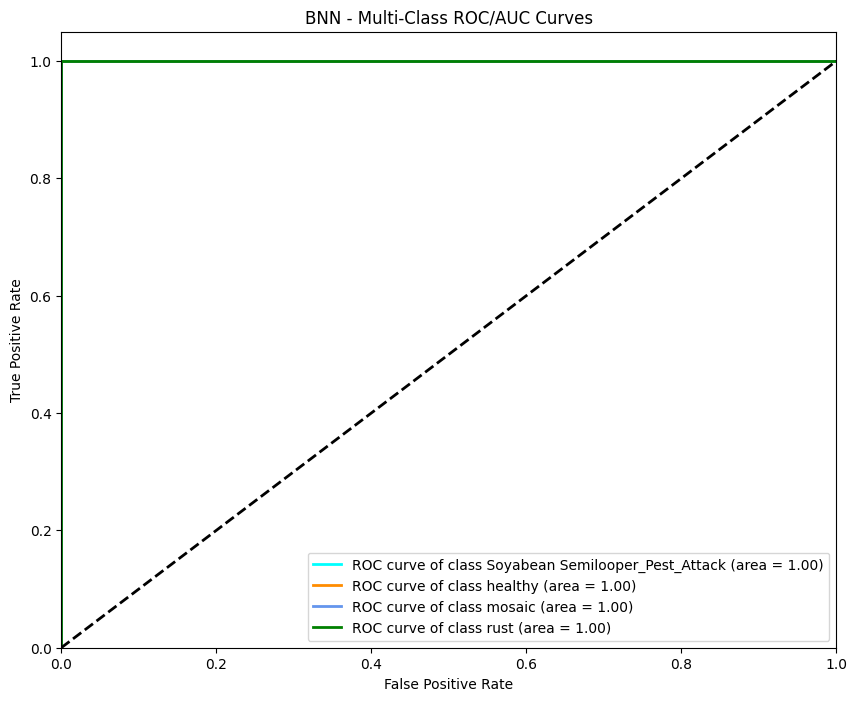

Epoch times chart saved to BNN_epoch_times.png


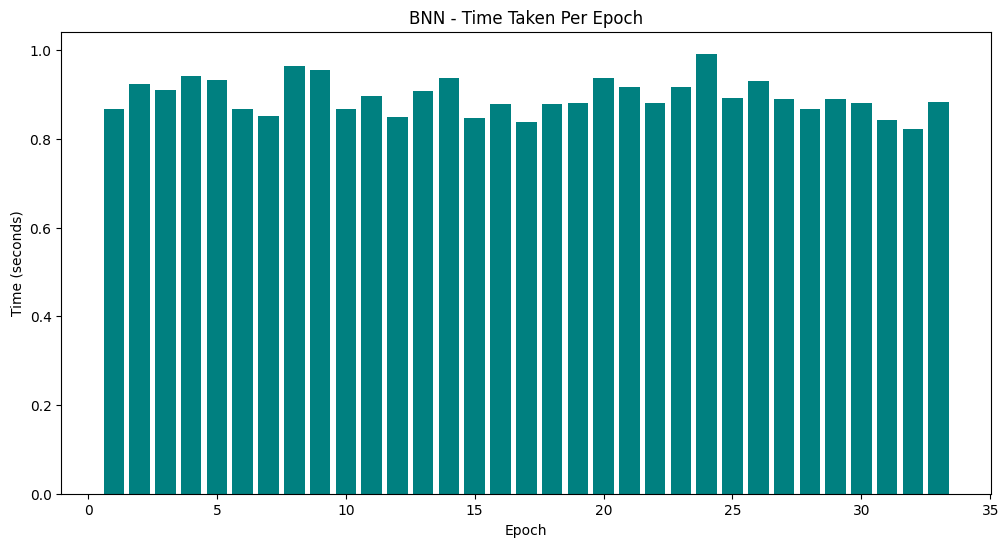

Configuration and dataset report saved to BNN_report.txt


--- FINAL BNN RESULTS ---
BNN Final Validation Accuracy: 100.00%
BNN Final Model Size: 35.14 MB


/tmp/ipykernel_5120/2873454332.py:71: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


In [71]:
# In[10]:
# --- Generate All Plots and Reports ---

# Call the functions defined in the previous cell
plot_class_balance(full_dataset, class_names, "BNN")
plot_roc_auc_curves(trained_bnn, val_loader, class_names, "BNN")
plot_epoch_times(history, "BNN")

# Save the final configuration and dataset summary report
save_report(Config, full_dataset, train_dataset, val_dataset, history, "BNN")


# --- Print Final Summary ---
print("\n\n--- FINAL BNN RESULTS ---")
print("="*25)
_, final_accuracy = evaluate_model(trained_bnn, val_loader, nn.CrossEntropyLoss())
model_size = get_model_size_mb(trained_bnn)
print(f"BNN Final Validation Accuracy: {final_accuracy:.2f}%")
print(f"BNN Final Model Size: {model_size:.2f} MB")
print("="*25)